### Imports

In [11]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

import torch
import neat
import visualize


### Global settings

In [12]:
seed = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data

In [13]:
csv_file_path = '../datamart/data_project_nel_final.csv'

# Read the CSV file into a DataFrame
dt = pd.read_csv(csv_file_path)
data = dt.to_numpy()

In [14]:
csv_file_path = '../datamart/y_lactose.csv'

y_lactose = pd.read_csv(csv_file_path)
target = y_lactose.to_numpy()

In [15]:
X_train, X_val, y_train, y_val = train_test_split(data, target)

In [16]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5)

In [17]:
[X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape]

[(243, 12), (243, 1), (40, 12), (40, 1), (41, 12), (41, 1)]

In [18]:
def eval_genomes_val(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        # Negative RMSE
        genome.fitness = 0.0
        for xi, xo in zip(X_train, y_train):
            output = net.activate(xi)
            genome.fitness += (output[0] - xo)**2
        genome.fitness = -(genome.fitness[0]/y_train.shape[0])**.5
        # Negative RMSE Validation
        genome.fitness_val = 0.0
        for xi, xo in zip(X_val, y_val):
            output = net.activate(xi)
            genome.fitness_val += (output[0] - xo)**2
        genome.fitness_val = -(genome.fitness_val[0]/y_val.shape[0])**.5

In [19]:
config_file = 'config-feedforward-lactose'
with open(config_file, 'r', encoding='utf-8') as f:
    print(f.read())

#--- parameters for the lactose experiment ---#

[NEAT]
# The function used to compute the termination 
# criterion from the set of genome fitnesses. 
fitness_criterion     = max

# When the fitness computed by fitness_criterion 
# meets or exceeds this threshold, the evolution 
# process will terminate, with a call to any 
# registered reporting class 'found_solution' method.
# Note
# The found_solution method is not called if the maximum 
# number of generations is reached without the above 
# threshold being passed.
fitness_threshold     = 0.

# If no_fitness_termination evaluates to True, 
# then the fitness_criterion and fitness_threshold are ignored 
# for termination; only valid if termination by a maximum number 
# of generations passed to population.Population.run() is enabled, 
# and the found_solution method is called upon 
# generation number termination.
no_fitness_termination = False

# The number of individuals in NEAT population.
pop_size              = 250

# If this e

Random search

In [20]:
from itertools import product
import configparser
import os
import neat
import pickle

# Define parameter ranges
param_grid = {
    'pop_size': [50, 100, 250, 500],
    'activation_mutate_rate': [0.1, 0.2, 0.5, 0.7],
    'aggregation_mutate_rate': [0.1, 0.2, 0.5, 0.7],
    'bias_mutate_rate': [0.1, 0.2, 0.5, 0.7],
    'weight_mutate_rate': [0.1, 0.2, 0.5, 0.7],
    'node_add_prob': [0.1, 0.2, 0.5, 0.7],
    'conn_add_prob': [0.1, 0.2, 0.5, 0.7],
    'elitism': [0, 1, 2],
    'survival_threshold': [0.1, 0.2, 0.5]
}

param_combinations = list(product(
    param_grid['pop_size'],
    param_grid['activation_mutate_rate'],
    param_grid['aggregation_mutate_rate'],
    param_grid['bias_mutate_rate'],
    param_grid['weight_mutate_rate'],
    param_grid['node_add_prob'],
    param_grid['conn_add_prob'],
    param_grid['elitism'],
    param_grid['survival_threshold']
))

random.seed(19)

# Choose 10 random combinations
random_combinations = random.sample(param_combinations, 10)

In [21]:
def run_neat_experiment(config, generations):
    
    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(False))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)

    # Run until a solution is found.
    winner = p.run(eval_genomes_val, generations)

    
    return winner, stats

In [22]:
import io

def create_neat_config(params):
    config = configparser.ConfigParser()
    config.read('config-feedforward-lactose', encoding='utf-8')

    config['NEAT']['pop_size'] = str(params[0])
    config['DefaultGenome']['activation_mutate_rate'] = str(params[1])
    config['DefaultGenome']['aggregation_mutate_rate'] = str(params[2])
    config['DefaultGenome']['bias_mutate_rate'] = str(params[3])
    config['DefaultGenome']['weight_mutate_rate'] = str(params[4])
    config['DefaultGenome']['node_add_prob'] = str(params[5])
    config['DefaultGenome']['conn_add_prob'] = str(params[6])
    config['DefaultReproduction']['elitism'] = str(params[7])
    config['DefaultReproduction']['survival_threshold'] = str(params[8])

    # Write the config to a string buffer
    config_string = io.StringIO()
    config.write(config_string)
    config_string.seek(0)
    
   # Write the config to a temporary file
    with open('temp_config.ini', 'w') as temp_config_file:
        temp_config_file.write(config_string.getvalue())

    neat_config = neat.Config(
        neat.DefaultGenome,
        neat.DefaultReproduction,
        neat.DefaultSpeciesSet,
        neat.DefaultStagnation,
        'temp_config.ini'
    )
    
    return neat_config


In [23]:
# Perform the grid search on the selected random combinations
results = []

for combination in random_combinations:
    neat_config = create_neat_config(combination)
    winner = run_neat_experiment(neat_config, 50)[0]
    fitness = winner.fitness_val
    results.append((combination, fitness))

best_combination, best_fitness = max(results, key=lambda x: x[1])

print(f"\nBest Parameters: {best_combination}")
print(f"Best Fitness: {best_fitness}")


 ****** Running generation 0 ****** 

Population's average fitness: -10.07351 stdev: 3.78080
Best fitness: -4.89104 - size: (6, 65) - species 1 - id 3
Average adjusted fitness: 0.693
Mean genetic distance 3.405, standard deviation 0.621
Population of 50 members in 1 species
Total extinctions: 0
Generation time: 0.302 sec

 ****** Running generation 1 ****** 

Population's average fitness: -6.02917 stdev: 1.89865
Best fitness: -2.41837 - size: (7, 66) - species 1 - id 93
Average adjusted fitness: 0.550
Mean genetic distance 3.014, standard deviation 0.896
Population of 50 members in 1 species
Total extinctions: 0
Generation time: 0.281 sec (0.292 average)

 ****** Running generation 2 ****** 

Population's average fitness: -4.23836 stdev: 1.29039
Best fitness: -1.54247 - size: (6, 54) - species 1 - id 116
Average adjusted fitness: 0.589
Mean genetic distance 2.654, standard deviation 0.904
Population of 50 members in 1 species
Total extinctions: 0
Generation time: 0.282 sec (0.289 aver

Use best params for final model

In [24]:
def eval_genomes_test(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        # Negative RMSE
        genome.fitness = 0.0
        for xi, xo in zip(X_train, y_train):
            output = net.activate(xi)
            genome.fitness += (output[0] - xo)**2
        genome.fitness = -(genome.fitness[0]/y_train.shape[0])**.5
        # Negative RMSE Validation
        genome.fitness_val = 0.0
        for xi, xo in zip(X_test, y_test):
            output = net.activate(xi)
            genome.fitness_val += (output[0] - xo)**2
        genome.fitness_val = -(genome.fitness_val[0]/y_val.shape[0])**.5

In [25]:
best_config = create_neat_config(best_combination)

In [28]:
# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(best_config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(False))
stats = neat.StatisticsReporter()
p.add_reporter(stats)

# Run until a solution is found.
winner = p.run(eval_genomes_test, 200)


 ****** Running generation 0 ****** 

Population's average fitness: -9.21925 stdev: 3.33771
Best fitness: -2.83623 - size: (6, 65) - species 1 - id 191
Average adjusted fitness: 0.686
Mean genetic distance 3.591, standard deviation 0.190
Population of 500 members in 1 species
Total extinctions: 0
Generation time: 2.923 sec

 ****** Running generation 1 ****** 

Population's average fitness: -5.58150 stdev: 2.00637
Best fitness: -2.05703 - size: (5, 51) - species 1 - id 621
Average adjusted fitness: 0.718
Mean genetic distance 3.440, standard deviation 0.314
Population of 500 members in 1 species
Total extinctions: 0
Generation time: 2.867 sec (2.895 average)

 ****** Running generation 2 ****** 

Population's average fitness: -4.67012 stdev: 1.19522
Best fitness: -0.98442 - size: (5, 50) - species 1 - id 1318
Average adjusted fitness: 0.726
Mean genetic distance 3.380, standard deviation 0.435
Population of 500 members in 1 species
Total extinctions: 0
Generation time: 2.810 sec (2.86

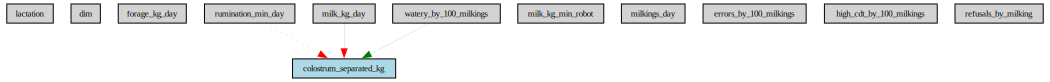

In [29]:
features = list(dt.columns)
input_names = {0: 'colostrum_separated_kg'}
for i in range(len(features)):
    input_names.update({-1*(i+1): features[i]})

visualize.draw_net(best_config, winner, True, node_names=input_names, prune_unused=False)


In [30]:
# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))



Best genome:
Key: 75975
Fitness: -0.06294193340700069
Nodes:
	0 DefaultNodeGene(key=0, bias=4.893375716675584, response=1.0, activation=identity, aggregation=mean)
Connections:
	DefaultConnectionGene(key=(-10, 0), weight=0.009477943533508448, enabled=True)
	DefaultConnectionGene(key=(-5, 0), weight=-0.10496045729500962, enabled=True)
	DefaultConnectionGene(key=(-4, 0), weight=-0.3320302618552094, enabled=False)


In [31]:
print(winner.fitness_val)

-0.05874005399541101


In [32]:
# Show output of the most fit genome against training data.
print('\nOutput:')

winner_net = neat.nn.FeedForwardNetwork.create(winner, best_config)

for xi, xo in zip(X_train[:3, :], y_train[:3]):
# for xi, xo in zip(xor_inputs, xor_outputs):
    output = winner_net.activate(xi)
    print("  expected output {!r}, got {!r}".format(xo, output))
    
out_train = []
for xi in X_train:
    output = winner_net.activate(xi)
    out_train.append(output[0])

out_val = []
for xi in X_val:
    output = winner_net.activate(xi)
    out_val.append(output[0])
    


Output:
  expected output array([4.87165997]), got [4.891436480417142]
  expected output array([4.84344561]), got [4.876874185234628]
  expected output array([4.9234945]), got [4.9391730010431685]


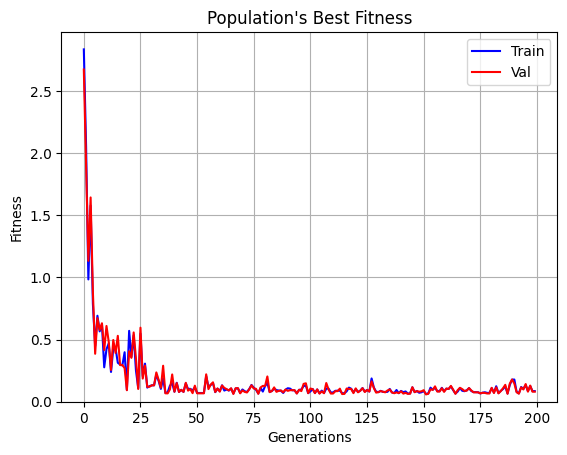

In [33]:
visualize.plot_stats(stats, ylog=False, view=True)

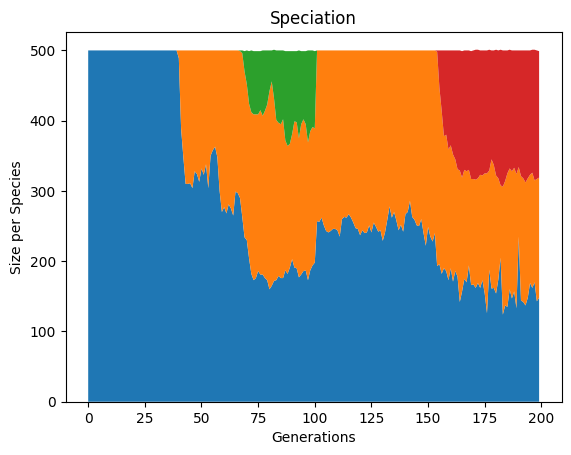

In [34]:
visualize.plot_species(stats, view=True)